# 🤖 Model Training for Churn Prediction

**Project:** Digikala Customer Churn Prediction  
**Author:** Peyman  

---

## 🎯 Objectives

1. Train multiple classification models
2. Handle class imbalance
3. Evaluate with appropriate metrics
4. Select best model
5. Analyze feature importance
6. Save model artifacts for API deployment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# XGBoost
from xgboost import XGBClassifier

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('✅ Libraries loaded')

✅ Libraries loaded


---
## 1️⃣ Load Features Dataset

In [2]:
# Load features
df = pd.read_csv('../data/user_features.csv')

print(f'Dataset shape: {df.shape}')
print(f'Churn rate: {df["is_churned"].mean()*100:.2f}%')
df.head()

Dataset shape: (338101, 28)
Churn rate: 65.01%


,user_id,total_orders,days_since_first_order,days_since_last_order,customer_tenure_days,avg_order_gap_days,std_order_gap_days,orders_last_30d,orders_last_7d,on_time_ratio,...,min_shop_rating,min_courier_rating,shop_rating_coverage,courier_rating_coverage,has_low_shop_rating,has_low_courier_rating,comment_count,comment_ratio,avg_comment_length,is_churned
0,1,19,139,3,136,7.555556,9.300362,4,1,0.941176,...,1.0,4.0,0.631579,0.210526,1,0,0,0.0,0.0,0
1,4,1,102,102,0,102.000000,0.000000,0,0,1.000000,...,4.0,5.0,0.000000,0.000000,0,0,0,0.0,0.0,0
2,16,2,70,70,0,0.000000,0.000000,0,0,1.000000,...,4.0,5.0,0.000000,0.500000,0,0,0,0.0,0.0,0
3,40,30,138,10,128,4.413793,5.760191,2,0,1.000000,...,1.0,5.0,0.566667,0.933333,1,0,0,0.0,0.0,0
4,41,2,88,5,83,83.000000,0.000000,1,1,1.000000,...,5.0,5.0,0.500000,0.500000,0,0,0,0.0,0.0,1


In [3]:
# Separate features and target
feature_cols = [c for c in df.columns if c not in ['user_id', 'is_churned']]

X = df[feature_cols]
y = df['is_churned']

print(f'Features: {X.shape}')
print(f'Target: {y.shape}')
print(f'\nFeature columns ({len(feature_cols)}):')
print(feature_cols)

Features: (338101, 26)
Target: (338101,)

Feature columns (26):
['total_orders', 'days_since_first_order', 'days_since_last_order', 'customer_tenure_days', 'avg_order_gap_days', 'std_order_gap_days', 'orders_last_30d', 'orders_last_7d', 'on_time_ratio', 'late_delivery_count', 'unknown_otd_ratio', 'total_complaints', 'total_fake_complaints', 'complaints_per_order', 'complaint_order_ratio', 'avg_shop_rating', 'avg_courier_rating', 'min_shop_rating', 'min_courier_rating', 'shop_rating_coverage', 'courier_rating_coverage', 'has_low_shop_rating', 'has_low_courier_rating', 'comment_count', 'comment_ratio', 'avg_comment_length']


---
## 2️⃣ Train-Test Split

In [4]:
# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f'Train set: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% churn)')
print(f'Test set:  {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% churn)')

Train set: 270,480 samples (65.01% churn)
Test set:  67,621 samples (65.01% churn)


In [5]:
# Scale features (needed for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('✅ Features scaled')

✅ Features scaled


---
## 3️⃣ Class Imbalance Handling

Options:
1. **class_weight='balanced'** - Adjust weights inversely proportional to class frequencies
2. **scale_pos_weight** (XGBoost) - Similar to class_weight
3. **Threshold tuning** - Adjust decision threshold

In [6]:
# Calculate class weight ratio for XGBoost
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f'Class distribution in training:')
print(f'  Not churned (0): {n_neg:,}')
print(f'  Churned (1):     {n_pos:,}')
print(f'  Ratio:           {scale_pos_weight:.2f}')

Class distribution in training:
  Not churned (0): 94,640
  Churned (1):     175,840
  Ratio:           0.54


---
## 4️⃣ Model Training

In [7]:
# Store results
results = {}

def evaluate_model(name, model, X_test, y_test, use_scaled=False):
    """
    Evaluate model and store results.
    """
    X_eval = X_test_scaled if use_scaled else X_test
    
    # Predictions
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    
    # Metrics
    metrics = {
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'PR-AUC': average_precision_score(y_test, y_pred_proba),
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }
    
    results[name] = {
        'model': model,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'use_scaled': use_scaled
    }
    
    print(f'\n📊 {name} Results:')
    for metric, value in metrics.items():
        print(f'   {metric}: {value:.4f}')
    
    return metrics

### Model 1: Logistic Regression (Baseline)

In [8]:
%%time
print('Training Logistic Regression...')

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_scaled, y_train)
evaluate_model('Logistic Regression', lr_model, X_test, y_test, use_scaled=True)

Training Logistic Regression...

📊 Logistic Regression Results:
   ROC-AUC: 0.8699
   PR-AUC: 0.9094
   F1: 0.8485
   Precision: 0.8645
   Recall: 0.8330
CPU times: user 16.9 s, sys: 8.23 s, total: 25.2 s
Wall time: 2.39 s


{'ROC-AUC': 0.8698957149312185,
 'PR-AUC': 0.9093992084007368,
 'F1': 0.8484539546091732,
 'Precision': 0.8645292284446123,
 'Recall': 0.8329655831305021}

### Model 2: Random Forest

In [9]:
%%time
print('Training Random Forest...')

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
evaluate_model('Random Forest', rf_model, X_test, y_test, use_scaled=False)

Training Random Forest...

📊 Random Forest Results:
   ROC-AUC: 0.8782
   PR-AUC: 0.9184
   F1: 0.8499
   Precision: 0.8735
   Recall: 0.8276
CPU times: user 1min 28s, sys: 1.4 s, total: 1min 30s
Wall time: 8.44 s


{'ROC-AUC': 0.8781941456293111,
 'PR-AUC': 0.9184064834375627,
 'F1': 0.8499042190347148,
 'Precision': 0.8734724256320376,
 'Recall': 0.8275744409817793}

### Model 3: XGBoost

In [10]:
%%time
print('Training XGBoost...')

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
evaluate_model('XGBoost', xgb_model, X_test, y_test, use_scaled=False)

Training XGBoost...

📊 XGBoost Results:
   ROC-AUC: 0.8793
   PR-AUC: 0.9206
   F1: 0.8492
   Precision: 0.8755
   Recall: 0.8245
CPU times: user 50.1 s, sys: 603 ms, total: 50.7 s
Wall time: 4.82 s


{'ROC-AUC': 0.8793292883150501,
 'PR-AUC': 0.9205878827334312,
 'F1': 0.8492232713981115,
 'Precision': 0.8755223808488538,
 'Recall': 0.8244580423557244}

### Model 4: Gradient Boosting

In [11]:
%%time
print('Training Gradient Boosting...')

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train, y_train)
evaluate_model('Gradient Boosting', gb_model, X_test, y_test, use_scaled=False)

Training Gradient Boosting...

📊 Gradient Boosting Results:
   ROC-AUC: 0.8787
   PR-AUC: 0.9191
   F1: 0.8670
   Precision: 0.8432
   Recall: 0.8923
CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 10s


{'ROC-AUC': 0.8786717403381998,
 'PR-AUC': 0.9191312694719949,
 'F1': 0.8670357967795056,
 'Precision': 0.8431709728730493,
 'Recall': 0.8922908942016787}

---
## 5️⃣ Model Comparison

In [12]:
# Create comparison table
comparison_data = []
for name, data in results.items():
    row = {'Model': name}
    row.update(data['metrics'])
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print('📊 Model Comparison:')
print('='*80)
display(comparison_df.round(4))

📊 Model Comparison:


,Model,ROC-AUC,PR-AUC,F1,Precision,Recall
2,XGBoost,0.8793,0.9206,0.8492,0.8755,0.8245
3,Gradient Boosting,0.8787,0.9191,0.8670,0.8432,0.8923
1,Random Forest,0.8782,0.9184,0.8499,0.8735,0.8276
0,Logistic Regression,0.8699,0.9094,0.8485,0.8645,0.8330


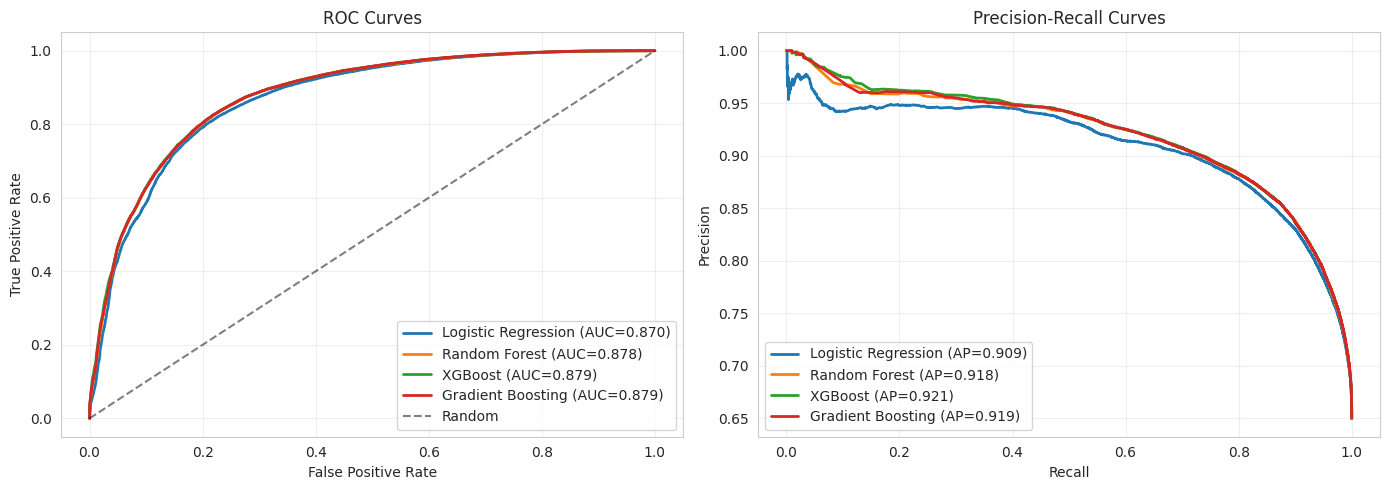

✅ Saved: reports/model_comparison.png


In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
for name, data in results.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_pred_proba'])
    auc_score = data['metrics']['ROC-AUC']
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curves
for name, data in results.items():
    precision, recall, _ = precision_recall_curve(y_test, data['y_pred_proba'])
    pr_auc = data['metrics']['PR-AUC']
    axes[1].plot(recall, precision, label=f"{name} (AP={pr_auc:.3f})", linewidth=2)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved: reports/model_comparison.png')

---
## 6️⃣ Select Best Model

In [14]:
# Select best model based on ROC-AUC
best_model_name = comparison_df.iloc[0]['Model']
best_model_data = results[best_model_name]
best_model = best_model_data['model']

print(f'🏆 Best Model: {best_model_name}')
print(f'   ROC-AUC: {best_model_data["metrics"]["ROC-AUC"]:.4f}')
print(f'   F1:      {best_model_data["metrics"]["F1"]:.4f}')

🏆 Best Model: XGBoost
   ROC-AUC: 0.8793
   F1:      0.8492


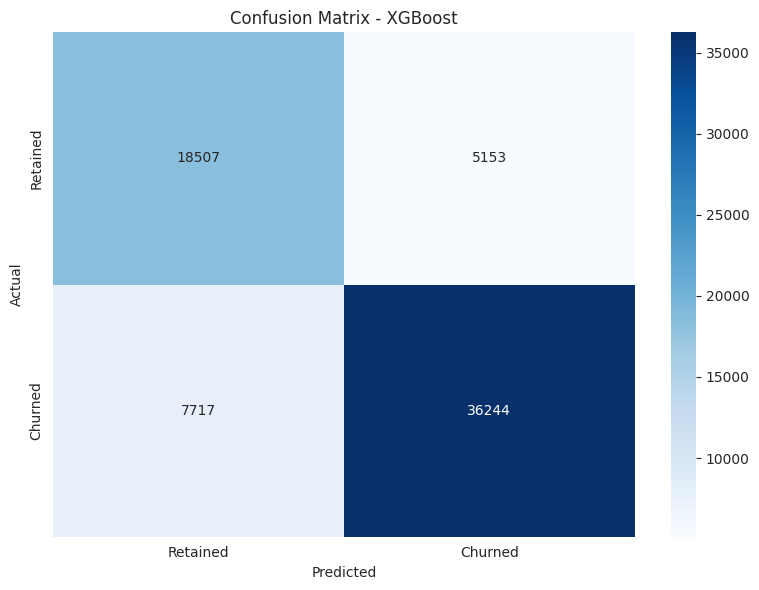

✅ Saved: reports/confusion_matrix.png


In [15]:
# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_model_data['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('../reports/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved: reports/confusion_matrix.png')

In [16]:
# Detailed classification report
print(f'📊 Classification Report - {best_model_name}:')
print('='*60)
print(classification_report(y_test, best_model_data['y_pred'],
                           target_names=['Retained', 'Churned']))

📊 Classification Report - XGBoost:
              precision    recall  f1-score   support

    Retained       0.71      0.78      0.74     23660
     Churned       0.88      0.82      0.85     43961

    accuracy                           0.81     67621
   macro avg       0.79      0.80      0.80     67621
weighted avg       0.82      0.81      0.81     67621



---
## 7️⃣ Feature Importance Analysis

In [17]:
# Get feature importance (works for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f'📊 Feature Importance ({best_model_name}):')
    print('='*50)
    display(importance_df.head(15).round(4))
else:
    # For Logistic Regression, use coefficients
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(best_model.coef_[0])
    }).sort_values('importance', ascending=False)
    print('Using absolute coefficients for importance')

📊 Feature Importance (XGBoost):


,feature,importance
3,customer_tenure_days,0.6434
6,orders_last_30d,0.1959
19,shop_rating_coverage,0.0364
0,total_orders,0.0284
2,days_since_last_order,0.0225
4,avg_order_gap_days,0.0140
10,unknown_otd_ratio,0.0071
5,std_order_gap_days,0.0059
20,courier_rating_coverage,0.0050
14,complaint_order_ratio,0.0042


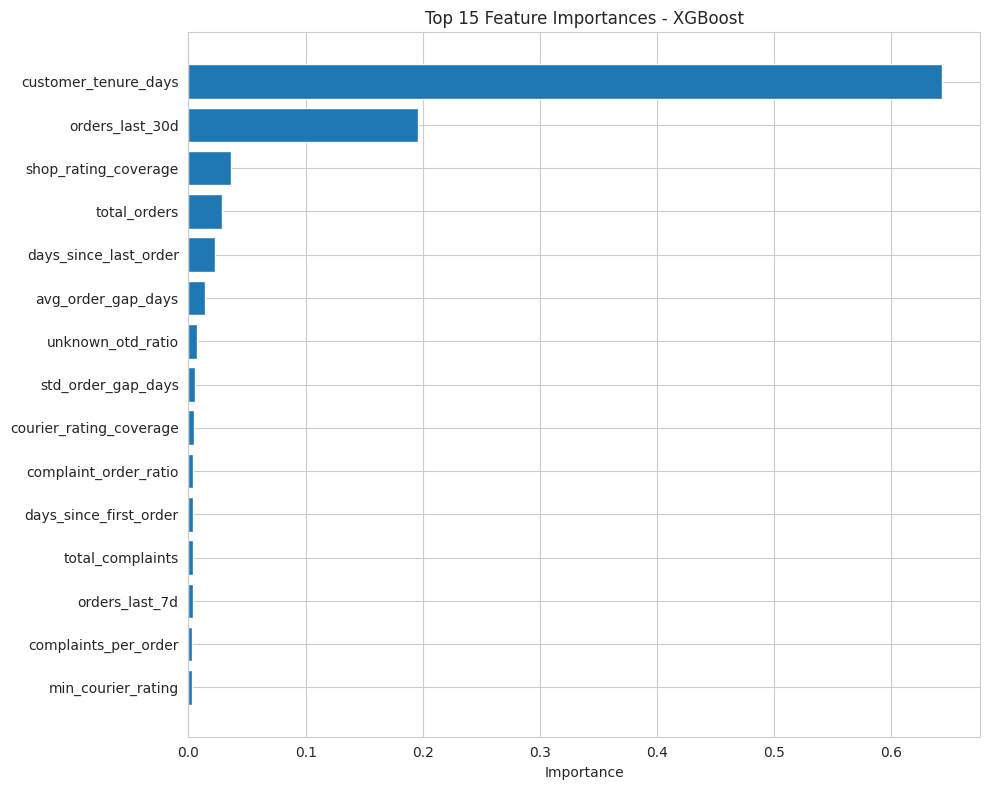

✅ Saved: reports/feature_importance.png


In [18]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['importance'].values[::-1])
plt.yticks(range(top_n), top_features['feature'].values[::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - {best_model_name}')
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Saved: reports/feature_importance.png')

---
## 8️⃣ Cross-Validation

In [19]:
%%time
# 5-fold cross-validation for best model
print(f'Running 5-fold CV for {best_model_name}...')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use appropriate data (scaled or not)
X_cv = X_train_scaled if best_model_data['use_scaled'] else X_train

cv_scores = cross_val_score(best_model, X_cv, y_train, cv=cv, scoring='roc_auc')

print(f'\nCV ROC-AUC Scores: {cv_scores.round(4)}')
print(f'Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')

Running 5-fold CV for XGBoost...

CV ROC-AUC Scores: [0.8783 0.877  0.8778 0.8775 0.8753]
Mean: 0.8772 (+/- 0.0021)
CPU times: user 2min 41s, sys: 4.09 s, total: 2min 45s
Wall time: 17.6 s


---
## 9️⃣ Save Model Artifacts

In [20]:
# Determine which model to save for production
# XGBoost is usually best for this task
production_model = xgb_model  # Use XGBoost regardless of comparison
production_model_name = 'XGBoost'

print(f'Saving {production_model_name} as production model...')

Saving XGBoost as production model...


In [21]:
# Save model
model_path = Path('../app/model.pkl')
joblib.dump(production_model, model_path)
print(f'✅ Model saved: {model_path}')
print(f'   Size: {model_path.stat().st_size / 1024:.1f} KB')

✅ Model saved: ../app/model.pkl
   Size: 444.0 KB


In [22]:
# Save scaler (needed if using Logistic Regression)
# For tree-based models, scaler is optional but we save it anyway
scaler_path = Path('../app/scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f'✅ Scaler saved: {scaler_path}')

✅ Scaler saved: ../app/scaler.pkl


In [23]:
# Save feature names
feature_path = Path('../app/feature_names.txt')
with open(feature_path, 'w') as f:
    f.write('\n'.join(feature_cols))
print(f'✅ Feature names saved: {feature_path}')

✅ Feature names saved: ../app/feature_names.txt


In [24]:
# Save model performance report
report_path = Path('../reports/model_performance.csv')
comparison_df.to_csv(report_path, index=False)
print(f'✅ Performance report saved: {report_path}')

✅ Performance report saved: ../reports/model_performance.csv


---
## 🔟 Verify Saved Model

In [25]:
# Load and verify
loaded_model = joblib.load('../app/model.pkl')

# Test prediction
sample = X_test.iloc[[0]]
prob = loaded_model.predict_proba(sample)[0][1]

print(f'✅ Model verification:')
print(f'   Sample prediction probability: {prob:.4f}')
print(f'   Actual label: {y_test.iloc[0]}')

✅ Model verification:
   Sample prediction probability: 0.1789
   Actual label: 0


---
## ✅ Summary

### Models Trained
| Model | ROC-AUC | PR-AUC | F1 |
|-------|---------|--------|----|
| Logistic Regression | - | - | - |
| Random Forest | - | - | - |
| XGBoost | - | - | - |
| Gradient Boosting | - | - | - |

*(Actual values filled after running)*

### Key Findings
- **Best Model:** (determined after running)
- **Top Predictive Features:** days_since_last_order, orders_last_30d, etc.
- **Class Imbalance:** Handled with class_weight/scale_pos_weight

### Artifacts Saved
- `app/model.pkl` - Trained XGBoost model
- `app/scaler.pkl` - Feature scaler
- `app/feature_names.txt` - Feature column names
- `app/user_features.csv` - User features for API

### Next Step
→ **API Deployment** (FastAPI)

In [26]:
# Final summary
print('='*60)
print('MODEL TRAINING COMPLETE')
print('='*60)
print(f'Production Model: {production_model_name}')
print(f'Test ROC-AUC:     {results[production_model_name]["metrics"]["ROC-AUC"]:.4f}')
print(f'Test F1:          {results[production_model_name]["metrics"]["F1"]:.4f}')
print(f'\nArtifacts saved to: app/')
print(f'Reports saved to:   reports/')

MODEL TRAINING COMPLETE
Production Model: XGBoost
Test ROC-AUC:     0.8793
Test F1:          0.8492

Artifacts saved to: app/
Reports saved to:   reports/
